In [ ]:
#Ongoing list of imports/packages
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
import networkx as nx
import seaborn as sns
import collections
from IPython.display import clear_output
import random
from scipy.stats import mannwhitneyu
import pandas as pd
from google.colab import drive
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.tree import plot_tree
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import datetime
!pip install fastcluster
import fastcluster


drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 1.0 MB/s eta 0:00:00
Mounted at /content/drive


## Data cleaning and reorganization from GEO accession
### Following the GEO accession there are two files. One file we are assuming comes from the manufacturer of the RNA microarray or as a read out has an index, NM ID, common gene abbreviation, full name of gene, GO accession and probe sequences. The second file has indexes and result values by patient. This also includes metadata on the patients.

###After uploading the .txt files. Metadata was removed and the files were merged so the final dataset has the corresponding NM IDs, index value, gene abb, and patient samples expression values.

###The next file contains all of the phenotypic data from the samples (there can be multiple samples from a patient)


In [ ]:
#uploading GEO accesion data
##Might have to change the file path
file_path = '/content/drive/MyDrive/20440_Project/GSE11223_series_matrix.txt'



#converting txt to data frame (removing metadata)
raw_file = pd.read_csv(file_path, delimiter='\t', skiprows=50, header=0)



#uploading Microarray GeneID data probes
#might have to change the file path
file_path = '/content/drive/MyDrive/20440_Project/GeneID_Probes.txt'


#converting txt to data frame
ID_raw = pd.read_csv(file_path, delimiter='\t', header = None)


<ipython-input-2-d8984220ce3d>:8: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_file = pd.read_csv(file_path, delimiter='\t', skiprows=50, header=0)


In [ ]:
#extracting ID_ref, NM_... ID, and Gene Names
ID_abb = ID_raw.iloc[:,[0,3,9]]
Column_names = ['ID_REF', 'NM_ID', 'GeneID']
ID_abb.columns = Column_names
#making sure everything is same dtype before merge
ID_abb.loc[:, 'ID_REF']=ID_abb.loc[:, "ID_REF"].astype(str)
ID_abb.loc[:, 'NM_ID']=ID_abb.loc[:, "NM_ID"].astype(str)
ID_abb.loc[:, 'GeneID']=ID_abb.loc[:, "GeneID"].astype(str)
#Replacing GeneID with NM_ID if blank
for index, row in ID_abb.iterrows():
  if row['GeneID']== 'nan':
    ID_abb.at[index, 'GeneID'] = row['NM_ID']

#Renaming ID_REF column on raw data
column = list(raw_file.columns)
raw_file.rename(columns= {column[0]: 'ID_REF'}, inplace = True)
#making sure everything is same dtype before merge
raw_file.loc[:, 'ID_REF'] = raw_file.loc[:, 'ID_REF'].astype(str)
#replacing NaN values with 0
raw_file = raw_file.fillna(0)

#adding NM_... ID and Gene Names to patient values
merged_df = pd.merge(raw_file, ID_abb, on='ID_REF', how ='left')

#extracting the name of the columns
column_names = list(merged_df.columns)

#adding NM_ID, GeneID to front of df
new_order = column_names[-2:] + column_names[:-2]
merged_df_reorg = merged_df[new_order]

In [ ]:
#uploading sample metadata


#might have to change file path
file_path = '/content/drive/MyDrive/20440_Project/GSE11223_newPheno.txt'



#converting txt to data frame
sample_info = pd.read_csv(file_path, delimiter='\t')
print(sample_info.info())

## Data manipulation
### According to Nobel et al the data has already been normalized and therefore we can go straight into the clustering procedure. We are going to perform heirarchical clustering using a variety of parameters and evaluators.  

                                       89        90         91        92     \
Normal Uninflamed sigmoid colon     0.038661  -0.13288  -0.042229  -0.21233   
Normal Uninflamed sigmoid colon.1   -0.10887  -0.10885   0.042197  -0.23983   
Normal Uninflamed sigmoid colon.2   -0.04431  -0.13558   0.017986  -0.33934   
Normal Uninflamed sigmoid colon.3  -0.033416  -0.11883   0.063459  -0.31396   
Normal Uninflamed sigmoid colon.4  -0.043601  -0.16435    0.07202   -0.4359   

                                      93         94         95       96     \
Normal Uninflamed sigmoid colon           0   0.034649   0.028586  0.15138   
Normal Uninflamed sigmoid colon.1  -0.11532   0.014877  -0.042214  0.21129   
Normal Uninflamed sigmoid colon.2  -0.44221  -0.054095   0.031149  0.19592   
Normal Uninflamed sigmoid colon.3  -0.24953  -0.058241  -0.057668  0.21552   
Normal Uninflamed sigmoid colon.4  -0.44009  -0.083175   -0.08265  0.23526   

                                      97         98     

KeyboardInterrupt: 

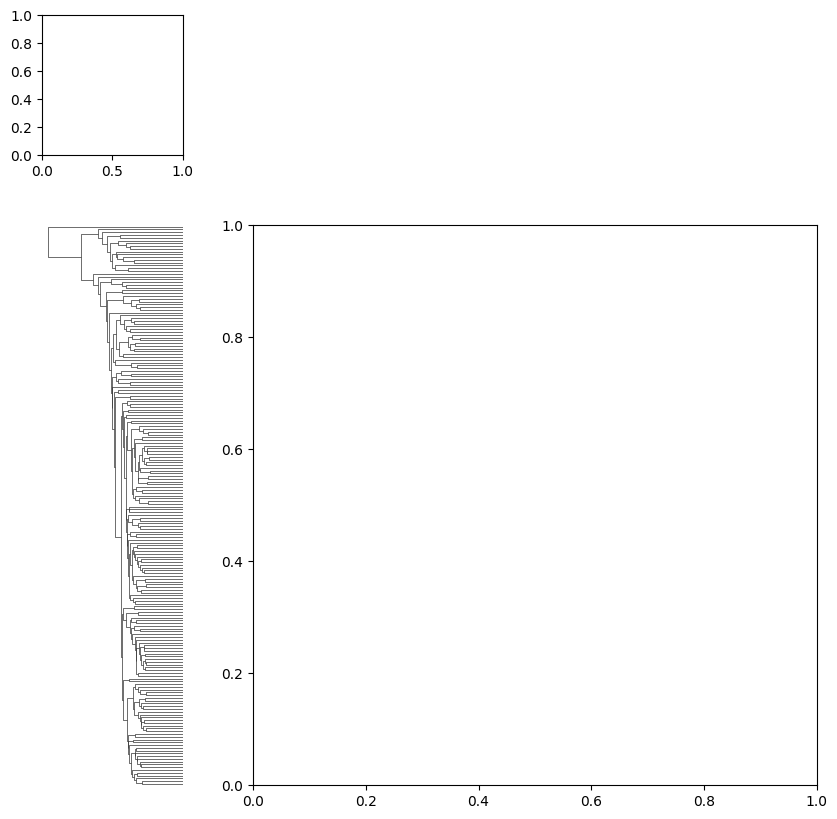

In [ ]:
#Transposing data so each sample is a row and each gene expression value is a column
merged_df_trans = merged_df_reorg.transpose()
Sample_type_ex = merged_df_trans.iloc[3:, 89:-1]
print(Sample_type_ex.head())

heatmap = sns.clustermap(Sample_type_ex.apply(pd.to_numeric, errors='coerce'), cmap='viridis', standard_scale=1)
plt.title('Heatmap and Clustering of Normalized Expression Data and Sample IDs')
heatmap.ax_heatmap.set_xlabel("GENE Expression Number")
heatmap.ax_heatmap.set_ylabel("Sample ID Number")

#might have to change file path
output_local = '/content/drive/MyDrive/20440_Project/Figures/'
#Figure should be depositied into the figure folder of the google drive folder
plt.savefig(output_local + 'heatmap.jpeg', format = 'jpeg')


### Determining the accuracy of the clustering with different n-clusters
(Normal vs UC n = 2)

(Normal vs inflammed n = 2)

(Biopsy type n = 4)

(Disease and biopsy type n = 14)

##Calculating the silhouette coefficient, calinski harabasz score, and the davies bouldin score for each scenerio

In [ ]:
Sample_type_ex_numeric = Sample_type_ex.apply(pd.to_numeric, errors='coerce').dropna()


In [ ]:
#Clustering by disease + inflammation + location n = 14
Sample_type_ex_numeric.columns = Sample_type_ex_numeric.columns.astype(str)
kmeansA = KMeans(n_clusters=14)
cluster_labelsA = kmeansA.fit_predict(Sample_type_ex_numeric)

# Calculate silhouette score
silhouette_avgA = silhouette_score(Sample_type_ex_numeric, cluster_labelsA)
print("Silhouette Score (n=14):", silhouette_avgA)

# Calculate Calinski-Harabasz Index
calinski_harabasz_score_valueA = calinski_harabasz_score(Sample_type_ex_numeric, cluster_labelsA)
print("Calinski-Harabasz Index (n=14):", calinski_harabasz_score_valueA)

# Calculate Davies-Bouldin Index
davies_bouldin_score_valueA = davies_bouldin_score(Sample_type_ex_numeric, cluster_labelsA)
print("Davies-Bouldin Index (n=14):", davies_bouldin_score_valueA)

# Add cluster labels to your dataframe
Sample_type_ex['Cluster_Labels_DIL'] = cluster_labelsA


#Clustering by disease n = 2
Sample_type_ex_numeric.columns = Sample_type_ex_numeric.columns.astype(str)
kmeansB = KMeans(n_clusters=2)
cluster_labelsB = kmeansB.fit_predict(Sample_type_ex_numeric)

# Calculate silhouette score
silhouette_avgB = silhouette_score(Sample_type_ex_numeric, cluster_labelsB)
print("Silhouette Score (n=2):", silhouette_avgB)

# Calculate Calinski-Harabasz Index
calinski_harabasz_score_valueB = calinski_harabasz_score(Sample_type_ex_numeric, cluster_labelsB)
print("Calinski-Harabasz Index (n=2):", calinski_harabasz_score_valueB)

# Calculate Davies-Bouldin Index
davies_bouldin_score_valueB = davies_bouldin_score(Sample_type_ex_numeric, cluster_labelsB)
print("Davies-Bouldin Index (n=2):", davies_bouldin_score_valueB)

# Add cluster labels to your dataframe
Sample_type_ex['Cluster_Labels_D'] = cluster_labelsB


#Clustering by location n= 4
Sample_type_ex_numeric.columns = Sample_type_ex_numeric.columns.astype(str)
kmeansC = KMeans(n_clusters=4)
cluster_labelsC = kmeansC.fit_predict(Sample_type_ex_numeric)

# Calculate silhouette score
silhouette_avgC = silhouette_score(Sample_type_ex_numeric, cluster_labelsC)
print("Silhouette Score (n=4):", silhouette_avgC)

# Calculate Calinski-Harabasz Index
calinski_harabasz_score_valueC = calinski_harabasz_score(Sample_type_ex_numeric, cluster_labelsC)
print("Calinski-Harabasz Index (n=4):", calinski_harabasz_score_valueC)

# Calculate Davies-Bouldin Index
davies_bouldin_score_valueC = davies_bouldin_score(Sample_type_ex_numeric, cluster_labelsC)
print("Davies-Bouldin Index (n=4):", davies_bouldin_score_valueC)

# Add cluster labels to your dataframe
Sample_type_ex['Cluster_Labels_L'] = cluster_labelsC



##Calculating the ARI and accuracy of the clustering

In [ ]:
#Rearranging and cleaning the data for analysis

sample_cluster_df = Sample_type_ex.iloc[:, [-3, -2, -1]]

# Convert index to a separate column
sample_cluster_df['Index_Column'] = sample_cluster_df.index

# Split the index column by spaces and expand it into separate columns
split_columns = sample_cluster_df['Index_Column'].str.split(expand=True)

# Assign the split columns to the DataFrame
sample_cluster_df2 = pd.concat([sample_cluster_df, split_columns], axis=1)

# Drop the temporary column if needed
sample_cluster_df2.drop(columns=['Index_Column'], inplace=True)

# Convert the last column to a separate column
sample_cluster_df2['Last_Column'] = sample_cluster_df2.iloc[:, -1]

# Split the last column by periods and expand it into separate columns
split_columns = sample_cluster_df2['Last_Column'].str.split('.', expand=True)

# Assign the split columns to the DataFrame
sample_cluster_df3 = pd.concat([sample_cluster_df2, split_columns], axis=1)

# Drop the temporary column if needed
sample_cluster_df3.drop(columns=['Last_Column'], inplace=True)

print(sample_cluster_df3)

NameError: name 'Sample_type_ex' is not defined

In [ ]:
#Setting index to UC or Normal
sample_cluster_df4 = sample_cluster_df3.set_index(sample_cluster_df3.columns[3])

# Extracting "Normal" or "UC" from the index and setting it as the first column
sample_cluster_df3['Biopsy_Type'] = sample_cluster_df3.index.str[0]

# Reordering the columns
sample_cluster_df3 = sample_cluster_df3[['Biopsy_Type'] + [col for col in sample_cluster_df3.columns if col != 'Biopsy_Type']]

# Resetting the index
sample_cluster_df3.reset_index(drop=True, inplace=True)
sample_cluster_df4 = sample_cluster_df3.iloc[:, [0,2]]

# Replace 'Normal' with 0 and 'UC' with 1 in the 'Biopsy_Type' column
sample_cluster_df4['Biopsy_Type'] = sample_cluster_df4['Biopsy_Type'].replace({'N': 0, 'U': 1})

# Get the ground truth labels
ground_truth_labels = sample_cluster_df4['Biopsy_Type'].values

# Assuming 'ground_truth_labels' are the true labels and 'cluster_labelsB' are the labels obtained from clustering
ari = adjusted_rand_score(ground_truth_labels, cluster_labelsB)

# Print the ARI score
print("Adjusted Rand Index (ARI):", ari)



# Assuming 'ground_truth_labels' are the true labels and 'cluster_labels' are the labels obtained from clustering
accuracy = accuracy_score(ground_truth_labels, cluster_labelsB)

# Print the accuracy score
print("Accuracy:", accuracy)


## Generating volcano plot of differentially expressed genes of UC compared to healthy samples
### Using a students t-test to calculate the p-values and adjusting using a bonferroni correction for multiple hypothesis testing. Calculating the fold change of UC/Healthy gene expression values. Final genes of interest must meet the requirements of having an adjusted p-value <0.05 and abs(log2(FC)) > 3

In [ ]:
# Determine the differentially expressed genes between healthy and UC
merged_df_trans2 = merged_df_trans.iloc[:, 89:-1]
merged_df_trans2.index = merged_df_trans2.index.str.split().str[0]
print(merged_df_trans2.head())
# Define the index names for healthy and disease samples
Healthy = 'Normal'
Disease = 'UC'

# Selecting rows
Healthy_rows = merged_df_trans2[merged_df_trans2.index == Healthy]
UC_rows = merged_df_trans2[merged_df_trans2.index == Disease]

# Initialize an empty DataFrame to store p-values
p_values_df = pd.DataFrame(columns=merged_df_trans2.columns)

# Perform t-test for each gene expression
for column in merged_df_trans2.columns:
    # Convert data to numeric to handle missing values
    Healthy_column_numeric = pd.to_numeric(Healthy_rows[column], errors='coerce')
    UC_column_numeric = pd.to_numeric(UC_rows[column], errors='coerce')

    # Drop missing values
    Healthy_column_numeric = Healthy_column_numeric.dropna()
    UC_column_numeric = UC_column_numeric.dropna()

    # Perform t-test if both healthy and disease samples exist
    if not (Healthy_column_numeric.empty or UC_column_numeric.empty):
        t_stat, p_val = ttest_ind(UC_column_numeric, Healthy_column_numeric)
        p_values_df[column] = [p_val]  # Add p-value for each gene to the DataFrame

# Bonferroni correction for multiple comparisons
p_values_corrected = p_values_df.apply(lambda x: x * len(p_values_df.columns), axis=1)

# Concatenate the DataFrame containing p-values to the original DataFrame
merged_df_trans2_with_pvalues = pd.concat([merged_df_trans2, p_values_corrected], ignore_index=True)

# Print the DataFrame with p-values added as the last row
print(merged_df_trans2_with_pvalues.head)


In [ ]:
print(merged_df_trans2)
print(merged_df_trans2_with_pvalues)

NameError: name 'merged_df_trans2' is not defined

In [ ]:
# Define the index names for healthy and disease samples
Healthy = 'Normal'
Disease = 'UC'

# Selecting rows
Healthy_rows = merged_df_trans2[merged_df_trans2.index == Healthy]
UC_rows = merged_df_trans2[merged_df_trans2.index == Disease]

# Initialize an empty DataFrame to store p-values
FC = pd.DataFrame(columns=merged_df_trans2.columns)

# Perform t-test for each gene expression
for column in merged_df_trans2.columns:
    # Convert data to numeric to handle missing values
    Healthy_column_numeric = pd.to_numeric(Healthy_rows[column], errors='coerce')
    UC_column_numeric = pd.to_numeric(UC_rows[column], errors='coerce')

    # Drop missing values
    Healthy_column_numeric = Healthy_column_numeric.dropna()
    UC_column_numeric = UC_column_numeric.dropna()

    # Calculate mean expression in healthy and disease samples
    mean_expression_healthy = Healthy_column_numeric.mean()
    mean_expression_UC = UC_column_numeric.mean()

    # Calculate fold change
    fold_change = mean_expression_UC / mean_expression_healthy
    # Add fold change to the DataFrame
    FC[column] = [fold_change]


# Concatenate the DataFrame containing p-values to the original DataFrame
EX_pval_FC = pd.concat([merged_df_trans2_with_pvalues, FC], ignore_index=True)

# Print the DataFrame with p-values added as the last row
print(EX_pval_FC)


In [ ]:
#Transforming all gene p-vals and FC
p_vals = EX_pval_FC.iloc[-2,:]
Fold_changes = EX_pval_FC.iloc[-1,:]

# Convert p-values to numeric (in case they are not already)
p_vals = pd.to_numeric(p_vals, errors='coerce')
# Take the logarithm of p-values (base 10) for better visualization
log10pval_all = -np.log10(p_vals)

# Convert p-values to numeric (in case they are not already)
Fold_changes = pd.to_numeric(Fold_changes, errors='coerce')
# Take the logarithm of p-values (base 10) for better visualization
log2FC_all = -np.log2(Fold_changes)


In [ ]:
# Filter only columns with p-values less than 0.05
significant_genes = EX_pval_FC.loc[:, EX_pval_FC.loc[205] < 0.05]

# Filter only columns with absulte FC values exceding 1
significant_genes2 = significant_genes.loc[:, (abs(significant_genes.loc[206]>1))]

#Transforming genes with p val < 0.05 and FC to overlay on volcano plot
p_vals = significant_genes2.iloc[-2,:]
Fold_changes = significant_genes2.iloc[-1,:]

# Convert p-values to numeric (in case they are not already)
p_vals = pd.to_numeric(p_vals, errors='coerce')
# Take the logarithm of p-values (base 10) for better visualization
log10pval = -np.log10(p_vals)

# Convert p-values to numeric (in case they are not already)
Fold_changes = pd.to_numeric(Fold_changes, errors='coerce')
# Take the logarithm of p-values (base 10) for better visualization
log2FC = -np.log2(Fold_changes)

In [ ]:
#plotting volcano plot
#Lines are displaying p-val and FC thresholds
#plt.scatter(log2FC, log10pval, alpha = 1, color = 'blue', label = 'significant')
VolcanoPlot = plt.scatter(log2FC_all, log10pval_all, alpha = 0.5, color = 'blue', label = 'all' )
plt.xlabel("log2(Fold Change) [UC/Healthy]")
plt.ylabel("-log(p-value)")
plt.title("Volcano plot differentially expressed genes between UC and Healthy ")
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)  # Add a horizontal line for significance threshold
plt.axvline(3, color='green', linestyle='--', linewidth=1)  # Add a vertical line for fold change threshold
plt.axvline(-3, color='green', linestyle='--', linewidth=1)  # Add a vertical line for fold change threshold

plt.savefig(output_local + 'VolcanoPlot', format = 'jpeg')


In [ ]:
# Filter only columns with p-values less than 0.05
significant_genes = EX_pval_FC.loc[:, EX_pval_FC.loc[205] < 0.05]

# Filter only columns with absolute FC values exceeding 1
significant_genes2 = significant_genes.loc[:, (abs(significant_genes.loc[206]) > 3)]

# Iterate over columns in the DataFrame
for column in significant_genes2.columns:
    # Check if the absolute FC value is within the desired range
    if abs(significant_genes2[column].loc[206]) <= 3:
        # Drop the column if the condition is not met
        significant_genes2.drop(column, axis=1, inplace=True)

GOI = significant_genes2.iloc[[1,205,206],:]
print(GOI)

In [ ]:
GOI2 = GOI.transpose()
print("Total number of Genes of Interest is",len(GOI2))
GOI2_sort = GOI2.sort_values(by=GOI2.columns[2], ascending = False)
print(GOI2_sort.iloc[0:10,:])

NameError: name 'GOI' is not defined